In [1]:
# Load Dependencies
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras.backend as K

from tensorflow.keras.applications import vgg19
from keras.preprocessing.image import load_img, img_to_array, save_img
from tensorflow.keras.models import Model

tfe = tf.contrib.eager

%matplotlib inline

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Allows us to evaluate tensors immediately
# which helps us avoid having to manage two graphs
tf.enable_eager_execution()

# Global Constants / Config

In [18]:
class CONFIG:
    HEIGHT = 512
    WIDTH = 512
    CHANNELS = 3
    CONTENT_LAYERS = ['block5_conv2']
    STYLE_LAYERS = [
        ('block1_conv1', 0.2),
        ('block2_conv1', 0.2),
        ('block3_conv1', 0.2),
        ('block4_conv1', 0.2),
        ('block5_conv1', 0.2)]

CONTENT_PATH = '../data/content/turtle.jpg'
STYLE_PATH = '../data/style/pop-1.jpeg'

## Helpers Functions - Images

In [4]:
def show_img(img, title):
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.show()
    
def get_img(path_to_img):
    return load_img(path_to_img, target_size=(CONFIG.HEIGHT, CONFIG.WIDTH, CONFIG.CHANNELS))

def load_and_process_img(path_to_img):
    """ Load and process image for VGG19 """
    img = get_img(path_to_img)
    img = img_to_array(img)
    img = np.float32(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def show_imgs(paths_to_imgs):
    plt.figure()
    num_cols = len(paths_to_imgs)
    for i, (path_to_img, title) in enumerate(paths_to_imgs):
        plt.subplot(1, num_cols, i+1)
        img = get_img(path_to_img)
        plt.imshow(img)
        if title:
            plt.title(title)
    plt.show()

def deprocess_img(img):
    x = img.copy()

    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
    if len(x.shape) != 3:
        raise ValueError("Invalid input to deprocess_img()")

    # Inverse of preprocessing
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    # Ensure we're in the range of (0, 255)
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def save_image(img, path_to_save):
    img = deprocess_img(img)
    save_img(path_to_save, img)
    
def generate_noise_image(path_to_content_img, noise_ratio = 0.6, show = True):
    """
    Generates a noisy image by adding random noise to the content_image
    """
    content_image = load_img(path_to_content_img, target_size=(CONFIG.HEIGHT, CONFIG.WIDTH, CONFIG.CHANNELS))
    content_image = img_to_array(content_image)
    # Generate a random noise_image
    noise_image = np.random.uniform(-20, 20, (CONFIG.HEIGHT, CONFIG.WIDTH, CONFIG.CHANNELS)).astype('float32')
    # Set the input_image to be a weighted average of the content_image and a noise_image
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    if show:
        show_img(np.clip(input_image, 0., 255.), 'Generated Image')
    input_image = np.expand_dims(input_image, axis=0)
    input_image = vgg19.preprocess_input(input_image)
    return input_image

# def generate_random_noise_image(show = True):
#     # Generate a random noise_image
#     noise_image = np.random.uniform(-20, 20, (CONFIG.HEIGHT, CONFIG.WIDTH, CONFIG.CHANNELS)).astype('float32')
#     # Set the input_image to be a weighted average of the content_image and a noise_image
#     input_image = 
#     if show:
#         show_img(np.clip(input_image, 0., 255.), 'Generated Image')
#     input_image = np.expand_dims(input_image, axis=0)
#     input_image = vgg19.preprocess_input(input_image)
#     return input_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


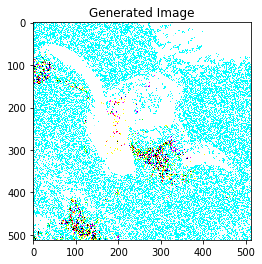

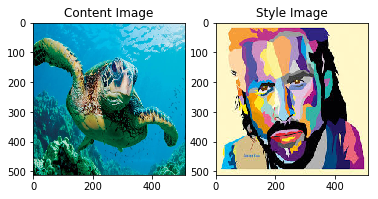

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


In [19]:
# Load and Show Images
content_img = load_and_process_img(CONTENT_PATH)
style_img = load_and_process_img(STYLE_PATH)
generated_img = generate_noise_image(CONTENT_PATH)

show_imgs([
    (CONTENT_PATH, 'Content Image'),
    (STYLE_PATH, 'Style Image'),  
])

print(content_img.shape)
print(style_img.shape)
print(generated_img.shape)

## Helper Functions - Model

In [6]:
def get_vgg_model():
    vgg = vgg19.VGG19(include_top=False, 
                weights='imagenet', 
                input_shape=(CONFIG.HEIGHT, CONFIG.WIDTH, CONFIG.CHANNELS),
                pooling='avg')
    vgg.trainable = False
    
    content_layers = [vgg.get_layer(layer_name).output for layer_name in CONFIG.CONTENT_LAYERS]
    style_layers = [vgg.get_layer(layer_name).output for layer_name,coeff in CONFIG.STYLE_LAYERS]
    model_output = content_layers + style_layers
    
    return Model(vgg.input, model_output)

def mean_squared_error(x, y):
    """ Calculate the mean squared error for two tensors """
    return tf.reduce_sum(tf.squared_difference(x, y))

def gram_matrix(x):
    return tf.matmul(x, tf.transpose(x))

In [7]:
gram_matrix(np.array([[1., 2., 3.],[1., 2., 3.]]))

<tf.Tensor: id=12, shape=(2, 2), dtype=float64, numpy=
array([[14., 14.],
       [14., 14.]])>

## Model - Content

In [8]:
def compute_content_cost(a_C, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()    
    constant = 1. / (4. * n_H * n_W * n_C)
    return constant * mean_squared_error(a_C, a_G)

In [9]:
# Test Compute Content Cost
a_C = tf.constant([[[[-1.683445,    1.8942857,   4.189092  ],
   [ 1.3846824,   3.8925915,   2.3524866 ],
   [-1.9202449,   4.6461368,  -1.0375276 ],
   [ 4.899456,   -7.5360813,   3.4091651 ]],

  [[-0.24858844, -2.4324749,   8.146585  ],
   [-1.7646906,   2.4694333,  -6.5859847 ],
   [ 0.7149899,   0.66104376,  4.199985  ],
   [ 2.5062335,   4.5016236,   1.5636368 ]],

  [[ 3.4233422,  -8.455175,    3.4438267 ],
   [ 1.2252892,   0.23202246,  1.4615505 ],
   [ 4.211294,   -4.7429867,  -2.338422  ],
   [ 1.3776655,  -3.3965898,   0.25865   ]],

  [[ 1.2512636,   7.4767985,   5.1221766 ],
   [10.617524,   -1.3393097,   0.99052405],
   [-5.410322,   -5.450125,   -1.7732203 ],
   [-4.097825,    4.843958,    2.7449982 ]]]])

a_G = tf.constant([[[[-0.39043474, -4.965909,   -5.387548  ],
   [ 4.572505,    1.1961036,   5.0099816 ],
   [ 1.7304354,  -0.13603461, -0.7514645 ],
   [-3.0110965,   1.0130516,   7.4561086 ]],

  [[ 0.51901615, -0.23328066, -0.8221154 ],
   [ 0.69788367,  1.5624137,   0.11127031],
   [ 3.7990131,  -0.5115707,  -5.364818  ],
   [-4.8868036,  -1.1914248,  -0.12090659]],

  [[ 7.0109277,  -1.2259245,   4.2369    ],
   [-5.399742,    3.159936,    7.259596  ],
   [ 1.643039,    7.3115473,   0.17630118],
   [-2.8375332,   1.839904,   -0.71492875]],

  [[ 5.2510543,   1.4054474,   2.8612938 ],
   [ 2.5214956,   4.3172836,   1.902338  ],
   [ 0.14868057, -1.2611487,  -0.78171515],
   [ 0.53150004, -0.8009285,   3.4972606 ]]]])

print("J_content = " + str(compute_content_cost(a_C, a_G).numpy()))
print("Should be =", str(6.76559))

J_content = 6.7655926
Should be = 6.76559


## Model - Style

In [10]:
def compute_style_cost_layer(a_S, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S_reshaped = tf.reshape(tf.transpose(a_S), [n_C, n_H * n_W])
    a_G_reshaped = tf.reshape(tf.transpose(a_G), [n_C, n_H * n_W])
    
    gram_S = gram_matrix(a_S_reshaped)
    gram_G = gram_matrix(a_G_reshaped)
    
    constant = 1./(4. * n_C**2 * (n_H * n_W)**2)
    return constant * mean_squared_error(gram_S, gram_G)

def compute_style_cost(all_a_S, all_a_G):
    J_style = 0
    for i, (layer_name, coeff) in enumerate(CONFIG.STYLE_LAYERS):
        a_S = all_a_S[i]
        a_G = all_a_G[i]
        J_style += coeff * compute_style_cost_layer(a_S, a_G)
    return J_style

In [11]:
# Test compute_style_cost_layer
a_S = tf.constant([[[[-1.683445,    1.8942857,   4.189092  ],
   [ 1.3846824,   3.8925915,   2.3524866 ],
   [-1.9202449,   4.6461368,  -1.0375276 ],
   [ 4.899456,   -7.5360813,   3.4091651 ]],

  [[-0.24858844, -2.4324749,   8.146585  ],
   [-1.7646906,   2.4694333,  -6.5859847 ],
   [ 0.7149899,   0.66104376,  4.199985  ],
   [ 2.5062335,   4.5016236,   1.5636368 ]],

  [[ 3.4233422,  -8.455175,    3.4438267 ],
   [ 1.2252892,   0.23202246,  1.4615505 ],
   [ 4.211294,   -4.7429867,  -2.338422  ],
   [ 1.3776655,  -3.3965898,   0.25865   ]],

  [[ 1.2512636,   7.4767985,   5.1221766 ],
   [10.617524,   -1.3393097,   0.99052405],
   [-5.410322,   -5.450125,   -1.7732203 ],
   [-4.097825,    4.843958,    2.7449982 ]]]])

a_G = tf.constant([[[[-0.39043474, -4.965909,   -5.387548  ],
   [ 4.572505,    1.1961036,   5.0099816 ],
   [ 1.7304354,  -0.13603461, -0.7514645 ],
   [-3.0110965,   1.0130516,   7.4561086 ]],

  [[ 0.51901615, -0.23328066, -0.8221154 ],
   [ 0.69788367,  1.5624137,   0.11127031],
   [ 3.7990131,  -0.5115707,  -5.364818  ],
   [-4.8868036,  -1.1914248,  -0.12090659]],

  [[ 7.0109277,  -1.2259245,   4.2369    ],
   [-5.399742,    3.159936,    7.259596  ],
   [ 1.643039,    7.3115473,   0.17630118],
   [-2.8375332,   1.839904,   -0.71492875]],

  [[ 5.2510543,   1.4054474,   2.8612938 ],
   [ 2.5214956,   4.3172836,   1.902338  ],
   [ 0.14868057, -1.2611487,  -0.78171515],
   [ 0.53150004, -0.8009285,   3.4972606 ]]]])
J_style_layer = compute_style_cost_layer(a_S, a_G)
    
print("J_style_layer = " + str(J_style_layer.numpy()))
print("Should be     =", str(9.19028))

J_style_layer = 9.190277
Should be     = 9.19028


In [12]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    return alpha * J_content + beta * J_style

## Calculate Gradient

In [13]:
def compute_gradient(content_image, style_image, generated_image, model):
    with tf.GradientTape(persistent=True) as tape:
        a_C = model(content_image)[0]
        a_S = model(style_image)[1:]
        a_G = model(generated_image)
        J_content = compute_content_cost(a_C, a_G[0])
        J_style = compute_style_cost(a_S, a_G[1:])
        cost = total_cost(J_content, J_style)
    return tape.gradient(cost, [generated_image])[0], cost, J_content, J_style

# Train the Model!

In [20]:
import time

def nst_train(content_image, style_image, generated_image, model, 
              save_dir, num_iterations = 200):
    start_time = time.time() # Time Iterations
    
    optimizer = tf.train.AdamOptimizer(2.0)
    
    show_img(deprocess_img(generated_img.numpy()), 'Starting Image')
    
    for i in range(num_iterations):
        # Get gradients and apply to generated_image
        grads, J, J_content, J_style = compute_gradient(content_image, style_image, generated_image, model)
        
        optimizer.apply_gradients([(grads, generated_image)])
        
        # Print / save image every N iterations
        if i % 10 == 0:
            end_time = time.time()
            print('Saving image: {}/{}.jpg'.format(save_dir, i))
            save_image(generated_image.numpy(), '{}/{}.jpg'.format(save_dir, i))
            print('Image Saved!')
            print('Total Time: ', end_time - start_time, 'secs', '\n')
            start_time = end_time
            show_img(deprocess_img(generated_img.numpy()), str(i))

    save_image(generated_image.numpy(), '{}/final.jpg'.format(save_dir))
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


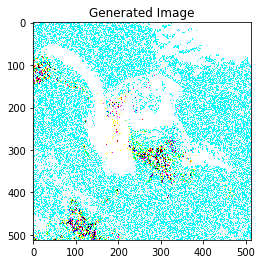

In [23]:
content_img = load_and_process_img(CONTENT_PATH)
style_img = load_and_process_img(STYLE_PATH)
generated_img = generate_noise_image(CONTENT_PATH)

content_img = K.constant(content_img, name='content_img', dtype='float32')
style_img = K.constant(style_img, name='style_img', dtype='float32')
generated_img = tfe.Variable(generated_img, name='generated_img', dtype='float32')

model = get_vgg_model()


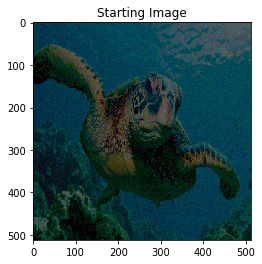

Saving image: ../images/pop/0.jpg
Image Saved!
Total Time:  21.858325004577637 secs 



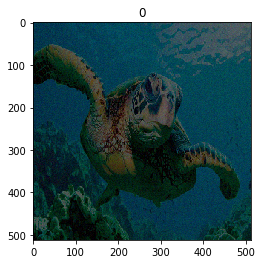

Saving image: ../images/pop/10.jpg
Image Saved!
Total Time:  230.9487431049347 secs 



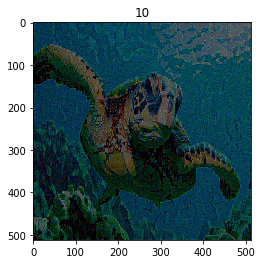

Saving image: ../images/pop/20.jpg
Image Saved!
Total Time:  223.2344138622284 secs 



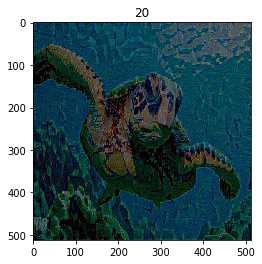

In [ ]:
nst_train(content_img, style_img, generated_img, model,
         save_dir='../images/pop')